Por la forma del input_shape solo se puede hacer con un timestep antes. Como es para tener una refierencia y ya está hacemos solo ese caso.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [33]:
import random
random.seed(123)

In [34]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)

In [35]:
def find_events(data, edificios, n_obs_antes, n_obs_despues):
    #DataFrame vacío para la salida
    datos_all_rooms = pd.DataFrame()
    
    #Para que no haya problemas de slice y .loc
    pd.options.mode.chained_assignment = None
    
    #Cogemos los datos, y seleccionamos las habitaciones de cada edificio 
    datos = data
    edificio = edificios
    mask = datos['block'].isin(edificio)
    datos = datos.loc[mask]
    rooms = datos['room'].unique()
    
    #Iteramos sobre cada una de las habitaciones
    for room in rooms:
        mask = datos['room'].isin([room])
        datos_room = datos.loc[mask]
        datos_room = datos_room.drop(columns=['dif_cons','cons_total','block','room', 'V12','V26','V5_0','V5_1','V5_2'],axis=1)
        
        #Ponemos la columna de V4 como string y buscamos una secuencia de un 1 seguido de n 0's
        #El número de 0's lo establece n_obs_despues
        text = datos_room.V4.fillna(2).astype(int).astype(str).str.cat()
        time = n_obs_despues*10 #Esto nos da el tiempo en min. Ej: n_obs_despues = 6 -> time = 60'

        sequence = list(np.repeat(str(0),time/10))
        sequence.insert(0,'1'*n_obs_antes)
        sequence= ''.join(sequence)
        pattern = f'(?:{sequence})'
        findings = re.finditer(pattern, text)
        events = [(m.start(0)) for m in findings]  

        df = pd.DataFrame()
        #Para cada una de las secuencias de 1 y 0's, hacemos la selección de las instancias correspondientes
        #del conjunto de datos y las añadimos a un df, que iremos completando con cada uno de los eventos
        for i in range(len(events)):
            ref_inicio = events[i]+n_obs_antes #+1 porque la referencia de inicio es el primer 0 y events empieza en el 1
            df1 = datos_room.iloc[range(ref_inicio - n_obs_antes, ref_inicio + n_obs_despues),:]
            data = df1
            #Una vez que tenemos los eventos quitamos la columna de V4
            data = data.drop(columns='V4')
            #n_vars = 1 if type(data) is list else data.shape[1]
            df = pd.concat([df,data])
        datos_all_rooms = pd.concat([datos_all_rooms, df])
    return datos_all_rooms

### Predicción para 1h

In [36]:
edificio = ['A','B','C']
n_obs_antes = 1 #Probar con3 
n_obs_despues = 6
datos_all_rooms = find_events(datos, edificio, n_obs_antes, n_obs_despues)

In [37]:
datos_all_rooms

,V2,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
Fecha,,,,,,,,,,,,,,,
2021-09-30 09:10:00+00:00,29.0,23.0,69.0,184.8,0.4,5.6,0.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-30 09:20:00+00:00,28.5,23.2,68.3,241.3,0.6,8.6,0.0,17.1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-30 09:30:00+00:00,28.3,23.4,67.8,375.6,0.4,8.8,0.0,17.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-30 09:40:00+00:00,28.5,24.2,64.7,381.2,0.3,17.1,0.0,17.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-09-30 09:50:00+00:00,28.7,24.1,64.5,226.0,0.3,193.5,0.0,17.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26 11:20:00+00:00,25.0,14.0,40.1,537.0,1.3,320.6,0.0,0.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11-26 11:30:00+00:00,25.0,14.2,39.3,544.6,1.3,307.6,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-11-26 11:40:00+00:00,25.0,14.3,38.3,551.9,1.7,289.3,0.0,0.3,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
def shuffle_df(datos, interval):
    df=datos
    arr_3D = df.values.reshape(-1,interval,df.shape[1])
    shuffle_idx = np.random.permutation(arr_3D.shape[0])
    arr_3D = arr_3D[shuffle_idx]
    shuffled_df = pd.DataFrame(arr_3D.reshape(df.shape[0],df.shape[1]))
    return shuffled_df

In [84]:
interval = n_obs_antes + n_obs_despues

In [85]:
df = datos_all_rooms
df = shuffle_df(df, interval)

In [86]:
def split_dataset(data, per_train, per_test, interval, n_obs_antes, n_obs_despues):
    df=data
    train = df.values[0:int((interval*np.ceil(df.shape[0]/interval*per_train)))]
    test =  df.values[int((interval*np.ceil(df.shape[0]/interval*per_train))):int((interval*np.ceil(df.shape[0]/interval*(per_train+per_test))))]
    val = df.values[int((interval*np.ceil(df.shape[0]/interval*(per_train+per_test)))):]
    #Escalado en train y test por separado. Si no se hace aquí ya no se puede porque todo lo que sigue es con arrays 3D
    scaler_y = StandardScaler()
    train_y = scaler_y.fit_transform(train[:,0].reshape(-1, 1))
    val_y = scaler_y.fit_transform(val[:,0].reshape(-1, 1))
    test_y = scaler_y.transform(test[:,0].reshape(-1, 1))
    scaler_x = StandardScaler()
    train_x = scaler_x.fit_transform(train[:,1:]) 
    val_x = scaler_x.fit_transform(val[:,1:]) 
    test_x = scaler_x.transform(test[:,1:])
    
    #Rehacemos los DataFrames con los datos escalados para poder hacer el split
    train = pd.concat([pd.DataFrame(train_y),pd.DataFrame(train_x)], axis=1)
    test = pd.concat([pd.DataFrame(test_y),pd.DataFrame(test_x)], axis=1)
    val = pd.concat([pd.DataFrame(val_y),pd.DataFrame(val_x)], axis=1)

    train = np.array(split(train, len(train)/(n_obs_antes+n_obs_despues)))
    test = np.array(split(test, len(test)/(n_obs_antes+n_obs_despues)))
    val = np.array(split(val, len(val)/(n_obs_antes+n_obs_despues)))
    return train, test, val, scaler_x, scaler_y

In [87]:
# split en train, val y test
per_train = 0.7
per_test = 0.15
train, test, val, scaler_x, scaler_y = split_dataset(df, per_train, per_test, interval, n_obs_antes, n_obs_despues)
print('shape: [muestras, pasos de tiempo, características]')
print('train shape:', train.shape)
print('val shape:', val.shape)
print('test shape:', test.shape)

shape: [muestras, pasos de tiempo, características]
train shape: (439, 9, 15)
val shape: (94, 9, 15)
test shape: (94, 9, 15)


In [88]:
def to_supervised(train, n_input, n_out):
    # Ponemos los datos en 2D: una entrada para cada muestra y paso de tiempo con las n características
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # Pasamos por todo el conjunto de datos, de step en step
    for _ in range(len(data)):
        # Definimos cuando empieza el input, cuando acaba, e igual para el output
        # En este caso el output empieza cuando acaba el input
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Iteramos mientras haya ejemplos
        if out_end <= len(data):
            X.append(data[in_start:in_end, :]) # X son todas las variables en t
            y.append(data[in_end:out_end, 0])  # y es la temperatura en t+1 (si n_out=1)
        # Pasamos al siguiente instante de tiempo
        in_start += 1
    X = array(X)
    y = array(y)
    return X, y

In [89]:
n_input = n_obs_antes
n_out = 1

In [90]:
train_x, train_y = to_supervised(train, n_input, n_out)
test_x, test_y = to_supervised(test, n_input, n_out)
val_x, val_y = to_supervised(val, n_input, n_out)
print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)  

train_x shape: (3948, 3, 15)
train_y shape: (3948, 1)
val_x shape: (843, 3, 15)
val_y shape: (843, 1)
test_x shape: (843, 3, 15)
test_y shape: (843, 1)


In [91]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[2])
test_x = test_x.reshape(test_x.shape[0],test_x.shape[2])
val_x = val_x.reshape(val_x.shape[0],val_x.shape[2])

ValueError: cannot reshape array of size 177660 into shape (3948,15)

In [92]:
rows_to_keep = n_obs_despues 
rows_to_drop = n_obs_antes
period = rows_to_keep + rows_to_drop

In [93]:
train_sel = (np.arange(len(train_x)) % period) < rows_to_keep
test_sel = (np.arange(len(test_x)) % period) < rows_to_keep
val_sel = (np.arange(len(val_x)) % period) < rows_to_keep

train_x = train_x[train_sel,:]
train_y = train_y[train_sel,:] 

test_x = test_x[test_sel,:]
test_y = test_y[test_sel,:] 

val_x = val_x[val_sel,:]
val_y = val_y[val_sel,:] 

print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)     
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 

train_x shape: (2634, 3, 15)
train_y shape: (2634, 1)
test_x shape: (564, 3, 15)
test_y shape: (564, 1)
val_x shape: (564, 3, 15)
val_y shape: (564, 1)


In [49]:
# define the keras model
# model = Sequential()
# model.add(Dense(50, input_dim=train_x.shape[1]))
# model.add(Dense(25))
# model.add(Dense(1))
#model.compile(loss="mean_absolute_error", optimizer='adam', metrics=['accuracy'])
#model.fit(train_x, train_y, epochs=150, batch_size=64)

In [98]:
def build_model(hp):
    model = Sequential()
    #Numero de nodos en la primera capa 
    hp_units1 = hp.Choice('input_unit',[25,50,100])
    model.add(Dense(units = hp_units1, input_dim=train_x.shape[1]))
    hp_units2 = hp.Choice('input_unit',[25,50,100])
    model.add(Dense(units = hp_units2))
    hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model

In [99]:
tuner1= BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=5,
        num_initial_points=2,
        seed = 123,
        overwrite=True
        )

TypeError: Dimension value must be integer or None or have an __index__ method, got value '(3, 15)' with type '<class 'tuple'>'

In [100]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [97]:
#Si esto da un error que dice algo de Oracle, se arregla borrando los json que hay en /untitle_project
tuner1.search(
        x=train_x,
        y=train_y,
        epochs=200,
        batch_size=128,
        validation_data=(val_x,val_y),
        verbose=2,
        shuffle=False,
        callbacks=[stop_early]
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
25                |?                 |input_unit
0.4               |?                 |Dropout_rate
0.01              |?                 |learning_rate

Epoch 1/200


ValueError: in user code:

    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\input_spec.py", line 247, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1of input shape to have value 3, but received input with shape (None, 3, 15)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 3, 15), dtype=float32)
      • training=True
      • mask=None


In [56]:
tuner1.results_summary(num_trials=1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
input_unit: 25
Dropout_rate: 0.0
learning_rate: 0.01
Score: 0.09650560468435287


In [57]:
model1 = tuner1.get_best_models(num_models=1)[0]

In [58]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                400       
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________


In [87]:
model1.save('model_temp_mlp_03_predsteps6_post6_prev1.h5')
#model1 = keras.models.load_model('model_temp_mlp_01_varall_predsteps6_post6_prev1.h5')

In [38]:
#SIN ACTUALIZAR
def predict(datos_test_x, datos_test_y, n_predict, n_obs_despues, model):
    test_y = datos_test_y
    test_x = datos_test_x
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos los índices i a 0
    i=0
    n = n_obs_despues - n_predict 
    m = n_predict   #Salto de n cada m
    test_index = [j for k in range(0,len(test_x), n+m) for j in range(k, m+k) if j<len(test_x)]
    data = test_x[test_index,:]
    input_x = data.reshape((test_x.shape[0], test_x.shape[1]))

    # Prediccion para cada paso de tiempo
    yhat = model.predict(input_x, verbose=0)
    yhat_sequence = yhat 

    # Guardamos las predicciones
    predictions.append(yhat_sequence)
        
    predictions = array(predictions)
    #Seleccionamos solo los ejemplos del conjunto de test que vamos a predecir
    test_y = test_y[test_index,:]
    return predictions, test_y

In [59]:
#ACTUALIZANDO
def predict(datos_test_x, datos_test_y, n_predict, n_obs_despues, model):
    test_y = datos_test_y
    test_x = datos_test_x
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos los índices i a 0
    i=0
    #Indice para hacer predicciones en un horizonte de tiempo concreto
    #Saltamos n filas cada m. Ej: tenemos n_obs_despues=12 pero queremos predecir solo la hora siguiente así
    #que predecimos 6 filas, saltamos otras 6 (que serían la 2a hora) y repetimos
    n = n_obs_despues - n_predict 
    m = n_predict   #Salto de n cada m
    test_index = [j for k in range(0,len(test_x), n+m) for j in range(k, m+k) if j<len(test_x)]
    for i in test_index:
        data = test_x[i,:]
        # Cogemos como input los valores del instante de tiempo anterior al que vamos a predecir
        # Recordar que el x lleva un lag de 1 respecto a la y, por eso es el elemento i y no el i-1
        # Le damos la forma que el modelo necesita para predecir
        input_x = data.reshape((1, test_x.shape[1]))
        
        # Prediccion para cada paso de tiempo
        yhat = model.predict(input_x, verbose=0)
        yhat_sequence = yhat[0] 

        # Guardamos las predicciones
        predictions.append(yhat_sequence)
        
        # Reescribimos el valor de la temperatura del siguiente paso con la prediccion
        # Añadimos una condición más para que en el último paso de cada evento no actualice, ya
        # que reescribiría datos de otro caso
        if i < len(test_x) and (i not in range(n_predict-1,len(test_x), n_obs_despues)):
            try: test_x[i+1,0] = yhat[0]
            except IndexError: continue
            #La excepción es porque al llegar al final no hay un i+1 que actualizar y salta un IndexError
        
    predictions = array(predictions)
    #Seleccionamos solo los ejemplos del conjunto de test que vamos a predecir
    test_y = test_y[test_index,:]
    return predictions, test_y

In [60]:
n_pred = n_obs_despues
prediction, test_y = predict(test_x, test_y, n_pred, n_obs_despues, model1)

In [61]:
prediction.shape

(618, 1)

In [63]:
pred_shape_0 = test.shape[0]
pred_shape_1 = n_obs_despues
# Ponemos la prediccion y el conjunto de test en 2D: muestras*timesteps
prediction = prediction.reshape(pred_shape_0, pred_shape_1)
test_y = test_y.reshape(pred_shape_0, pred_shape_1)

print('prediction shape:', prediction.shape)
print('test_y shape:', test_y.shape)

prediction shape: (103, 6)
test_y shape: (103, 6)


In [64]:
prediction = scaler_y.inverse_transform(prediction)
test_y = scaler_y.inverse_transform(test_y)

In [65]:
#ACTUALIZANDO
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.814
Test CVRMSE: 2.907
Test R squared: 0.915


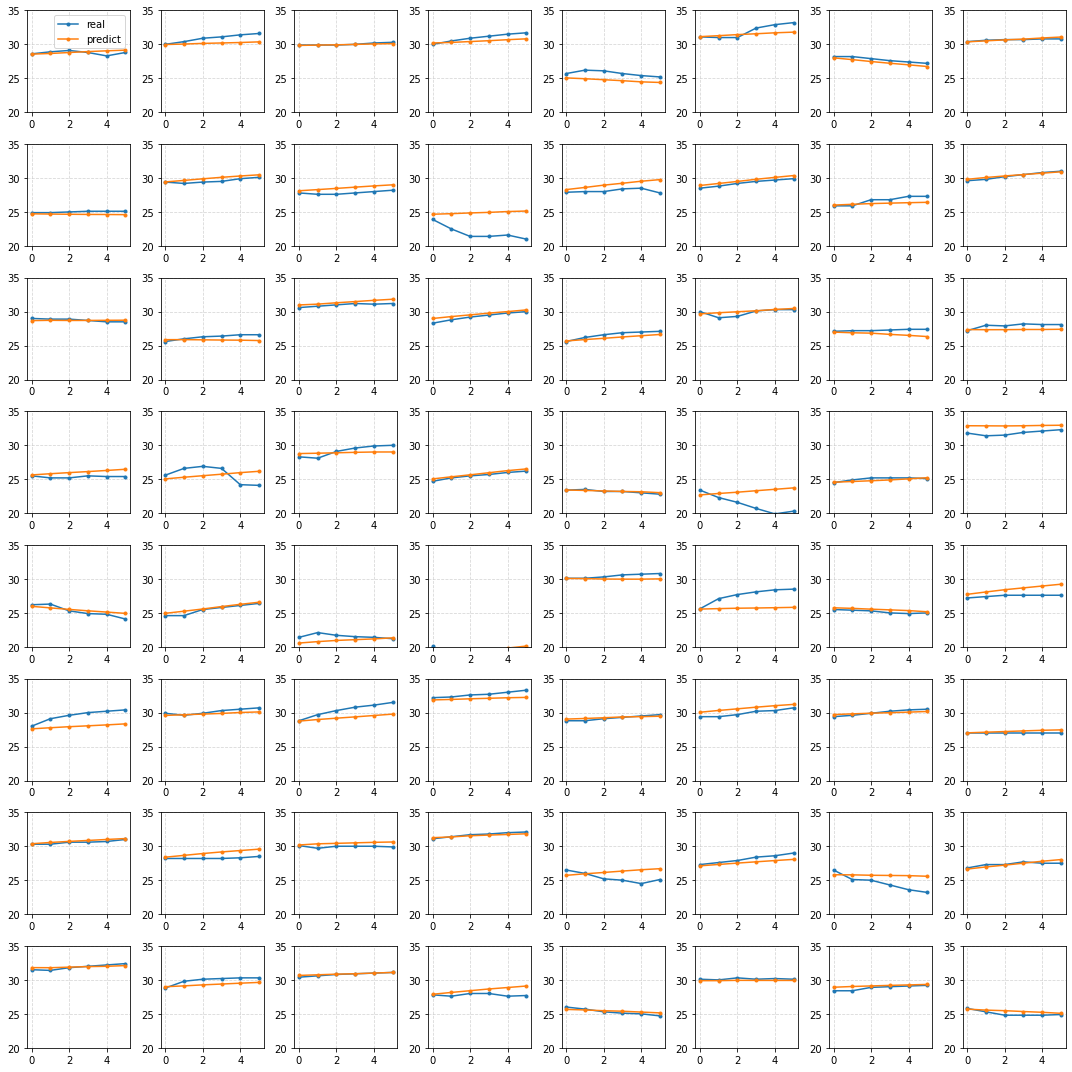

In [66]:
#ACTUALIZANDO
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k+i,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

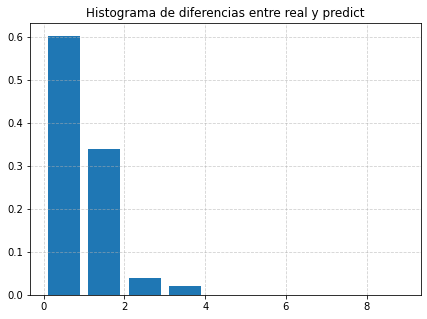

In [129]:
differences = np.abs((prediction - test_y).mean(axis=1)).round(0).astype(int)
differences

fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.hist(differences, bins= [0,1,2,3,4,5,6,7,8,9], density=True, rwidth=0.8, align='mid')
#plt.xticks(np.arange(0, 10, 1))
plt.title("Histograma de diferencias entre real y predict")
plt.show()

In [43]:
#SIN ACTUALIZAR
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.330
Test CVRMSE: 1.161
Test R squared: 0.979


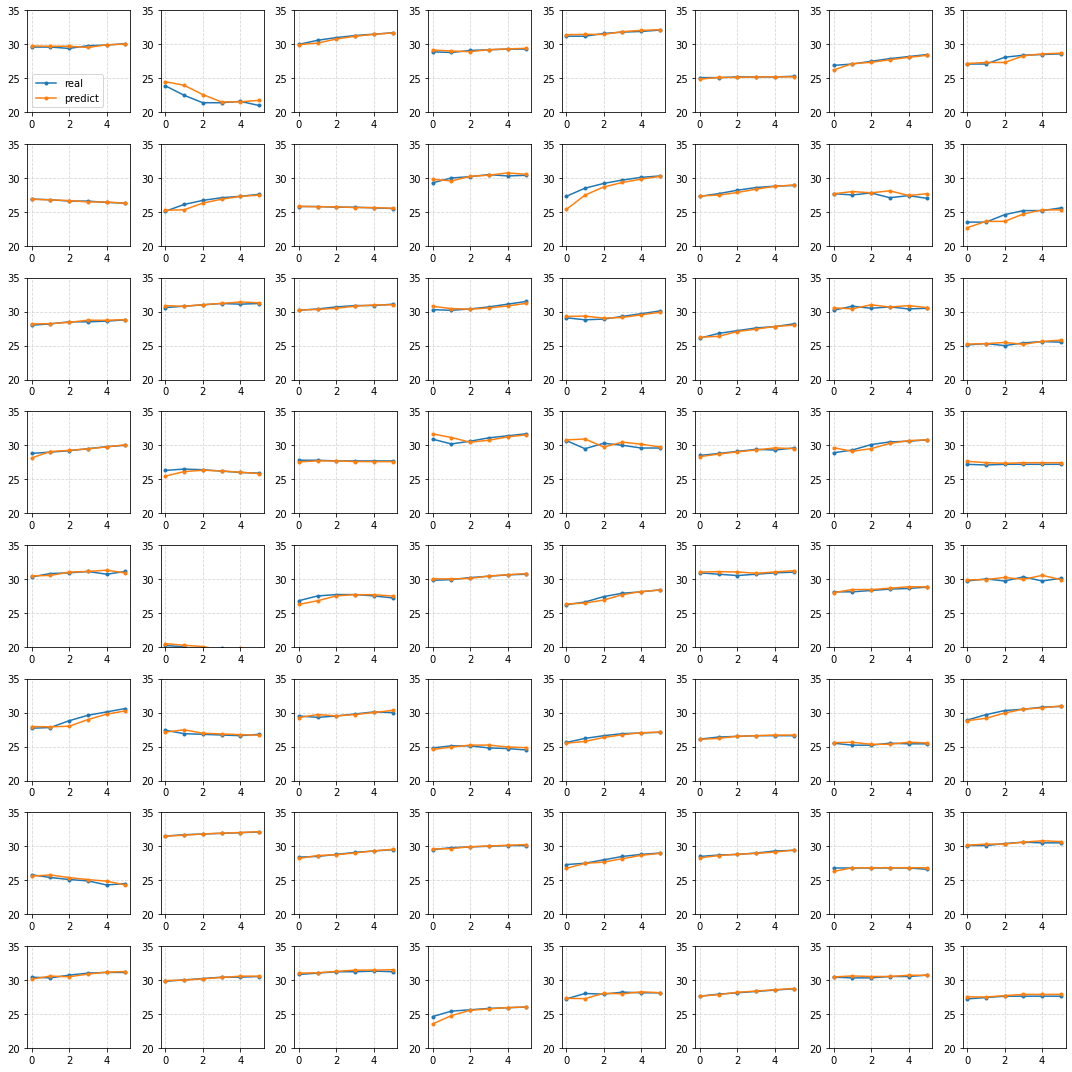

In [44]:
#SIN ACTUALIZAR
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k+i,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

### Predicción para 2h

In [60]:
edificio = ['A','B','C']
n_obs_antes = 1
n_obs_despues = 12
datos_all_rooms = find_events(datos, edificio, n_obs_antes, n_obs_despues)

In [61]:
interval = n_obs_antes + n_obs_despues

In [62]:
df = datos_all_rooms
np.random.seed(123)
df = shuffle_df(df, interval)

In [63]:
per_train = 0.7
per_test = 0.15
train, test, val, scaler_x, scaler_y = split_dataset(df, per_train, per_test, interval, n_obs_antes, n_obs_despues)
print('shape: [muestras, pasos de tiempo, características]')
print('train shape:', train.shape)
print('val shape:', val.shape)
print('test shape:', test.shape)

shape: [muestras, pasos de tiempo, características]
train shape: (453, 13, 16)
val shape: (96, 13, 16)
test shape: (97, 13, 16)


In [64]:
n_input = n_obs_antes
n_out = 1

In [65]:
train_x, train_y = to_supervised(train, n_input, n_out)
test_x, test_y = to_supervised(test, n_input, n_out)
val_x, val_y = to_supervised(val, n_input, n_out)
print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)  

train_x shape: (5888, 1, 16)
train_y shape: (5888, 1)
val_x shape: (1247, 1, 16)
val_y shape: (1247, 1)
test_x shape: (1260, 1, 16)
test_y shape: (1260, 1)


In [66]:
train_x = train_x.reshape(train_x.shape[0],train_x.shape[2])
test_x = test_x.reshape(test_x.shape[0],test_x.shape[2])
val_x = val_x.reshape(val_x.shape[0],val_x.shape[2])

rows_to_keep = n_obs_despues 
rows_to_drop = n_obs_antes
period = rows_to_keep + rows_to_drop

train_sel = (np.arange(len(train_x)) % period) < rows_to_keep
test_sel = (np.arange(len(test_x)) % period) < rows_to_keep
val_sel = (np.arange(len(val_x)) % period) < rows_to_keep

train_x = train_x[train_sel,:]
train_y = train_y[train_sel,:] 

test_x = test_x[test_sel,:]
test_y = test_y[test_sel,:] 

val_x = val_x[val_sel,:]
val_y = val_y[val_sel,:] 

print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)     
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 

train_x shape: (5436, 16)
train_y shape: (5436, 1)
test_x shape: (1164, 16)
test_y shape: (1164, 1)
val_x shape: (1152, 16)
val_y shape: (1152, 1)


In [137]:
def build_model(hp):
    model = Sequential()
    hp_units1 = hp.Choice('input_unit1',[25,50,100])
    model.add(Dense(units = hp_units1, input_dim=train_x.shape[1]))
    hp_units2 = hp.Choice('input_unit2',[25,50,100])
    model.add(Dense(units = hp_units2))
    hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model

In [138]:
tuner2= BayesianOptimization(
        build_model,
        objective='loss',
        max_trials=15,
        num_initial_points=2,
        seed = 123,
        overwrite=True
        )

In [54]:
stop_early = keras.callbacks.EarlyStopping(monitor='var_loss', mode='min', patience=10)

In [55]:
tuner2.search(
        x=train_x,
        y=train_y,
        epochs=100,
        batch_size=128,
        validation_data=(val_x,val_y),
        verbose=2,
        shuffle=False,
        callbacks=[stop_early]
)

Trial 15 Complete [00h 00m 07s]
loss: 0.06911984831094742

Best loss So Far: 0.06890633702278137
Total elapsed time: 00h 01m 36s
INFO:tensorflow:Oracle triggered exit


In [56]:
tuner2.results_summary(num_trials=1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
input_unit: 25
Dropout_rate: 0.0
learning_rate: 0.0001
Score: 0.06890633702278137


In [57]:
model2 = tuner2.get_best_models(num_models=1)[0]

In [58]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                425       
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [67]:
#model2.save('model_temp_mlp_02_varall_predsteps12_post12_prev1.h5')
model2 = keras.models.load_model('model_temp_mlp_02_varall_predsteps12_post12_prev1.h5')

In [53]:
#SIN ACTUALIZAR
def predict(datos_test_x, datos_test_y, n_predict, n_obs_despues, model):
    test_y = datos_test_y
    test_x = datos_test_x
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos los índices i a 0
    i=0
    n = n_obs_despues - n_predict 
    m = n_predict   #Salto de n cada m
    test_index = [j for k in range(0,len(test_x), n+m) for j in range(k, m+k) if j<len(test_x)]
    data = test_x[test_index,:]
    input_x = data.reshape((test_x.shape[0], test_x.shape[1]))

    # Prediccion para cada paso de tiempo
    yhat = model.predict(input_x, verbose=0)
    yhat_sequence = yhat 

    # Guardamos las predicciones
    predictions.append(yhat_sequence)
        
    predictions = array(predictions)
    #Seleccionamos solo los ejemplos del conjunto de test que vamos a predecir
    test_y = test_y[test_index,:]
    return predictions, test_y

In [68]:
#ACTUALIZANDO
def predict(datos_test_x, datos_test_y, n_predict, n_obs_despues, model):
    test_y = datos_test_y
    test_x = datos_test_x
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos los índices i a 0
    i=0
    #Indice para hacer predicciones en un horizonte de tiempo concreto
    #Saltamos n filas cada m. Ej: tenemos n_obs_despues=12 pero queremos predecir solo la hora siguiente así
    #que predecimos 6 filas, saltamos otras 6 (que serían la 2a hora) y repetimos
    n = n_obs_despues - n_predict 
    m = n_predict   #Salto de n cada m
    test_index = [j for k in range(0,len(test_x), n+m) for j in range(k, m+k) if j<len(test_x)]
    for i in test_index:
        data = test_x[i,:]
        # Cogemos como input los valores del instante de tiempo anterior al que vamos a predecir
        # Recordar que el x lleva un lag de 1 respecto a la y, por eso es el elemento i y no el i-1
        # Le damos la forma que el modelo necesita para predecir
        input_x = data.reshape((1, test_x.shape[1]))
        
        # Prediccion para cada paso de tiempo
        yhat = model.predict(input_x, verbose=0)
        yhat_sequence = yhat[0] 

        # Guardamos las predicciones
        predictions.append(yhat_sequence)
        
        # Reescribimos el valor de la temperatura del siguiente paso con la prediccion
        # Añadimos una condición más para que en el último paso de cada evento no actualice, ya
        # que reescribiría datos de otro caso
        if i < len(test_x) and (i not in range(n_predict-1,len(test_x), n_obs_despues)):
            try: test_x[i+1,0] = yhat[0]
            except IndexError: continue
            #La excepción es porque al llegar al final no hay un i+1 que actualizar y salta un IndexError
        
    predictions = array(predictions)
    #Seleccionamos solo los ejemplos del conjunto de test que vamos a predecir
    test_y = test_y[test_index,:]
    return predictions, test_y

In [69]:
n_pred = n_obs_despues
prediction, test_y = predict(test_x, test_y, n_pred, n_obs_despues, model2)

In [70]:
prediction

array([[-1.4995708],
       [-1.4989214],
       [-1.5011607],
       ...,
       [ 1.8272917],
       [ 1.866933 ],
       [ 1.9056971]], dtype=float32)

In [71]:
pred_shape_0 = test.shape[0]
pred_shape_1 = n_obs_despues
# Ponemos la prediccion y el conjunto de test en 2D: muestras*timesteps
prediction = prediction.reshape(pred_shape_0, pred_shape_1)
test_y = test_y.reshape(pred_shape_0, pred_shape_1)

print('prediction shape:', prediction.shape)
print('test_y shape:', test_y.shape)

prediction shape: (97, 12)
test_y shape: (97, 12)


In [72]:
prediction = scaler_y.inverse_transform(prediction)
test_y = scaler_y.inverse_transform(test_y)

In [73]:
#ACTUALIZANDO
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 1.120
Test CVRMSE: 3.996
Test R squared: 0.860


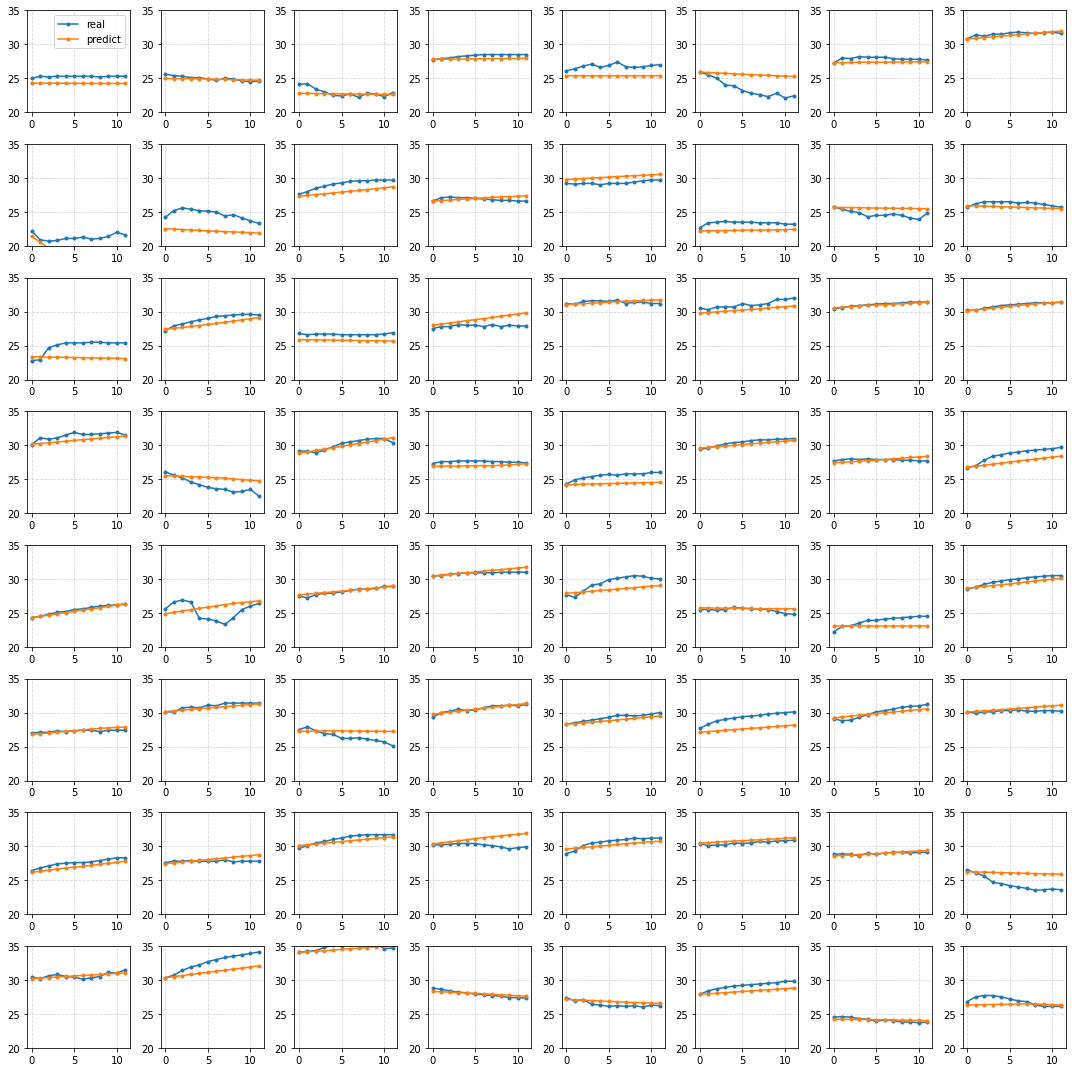

In [74]:
#ACTUALIZANDO
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k+i,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

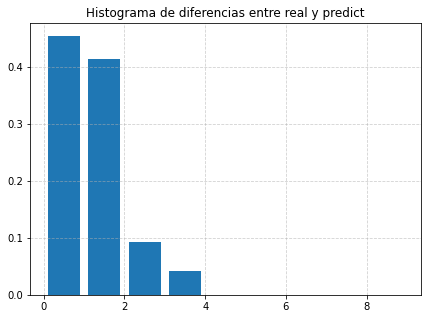

In [157]:
differences = np.abs((prediction - test_y).mean(axis=1)).round(0).astype(int)
differences

fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.hist(differences, bins= [0,1,2,3,4,5,6,7,8,9], density=True, rwidth=0.8, align='mid')
#plt.xticks(np.arange(0, 10, 1))
plt.title("Histograma de diferencias entre real y predict")
plt.show()

In [58]:
#SIN ACTUALIZAR
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.307
Test CVRMSE: 1.096
Test R squared: 0.987


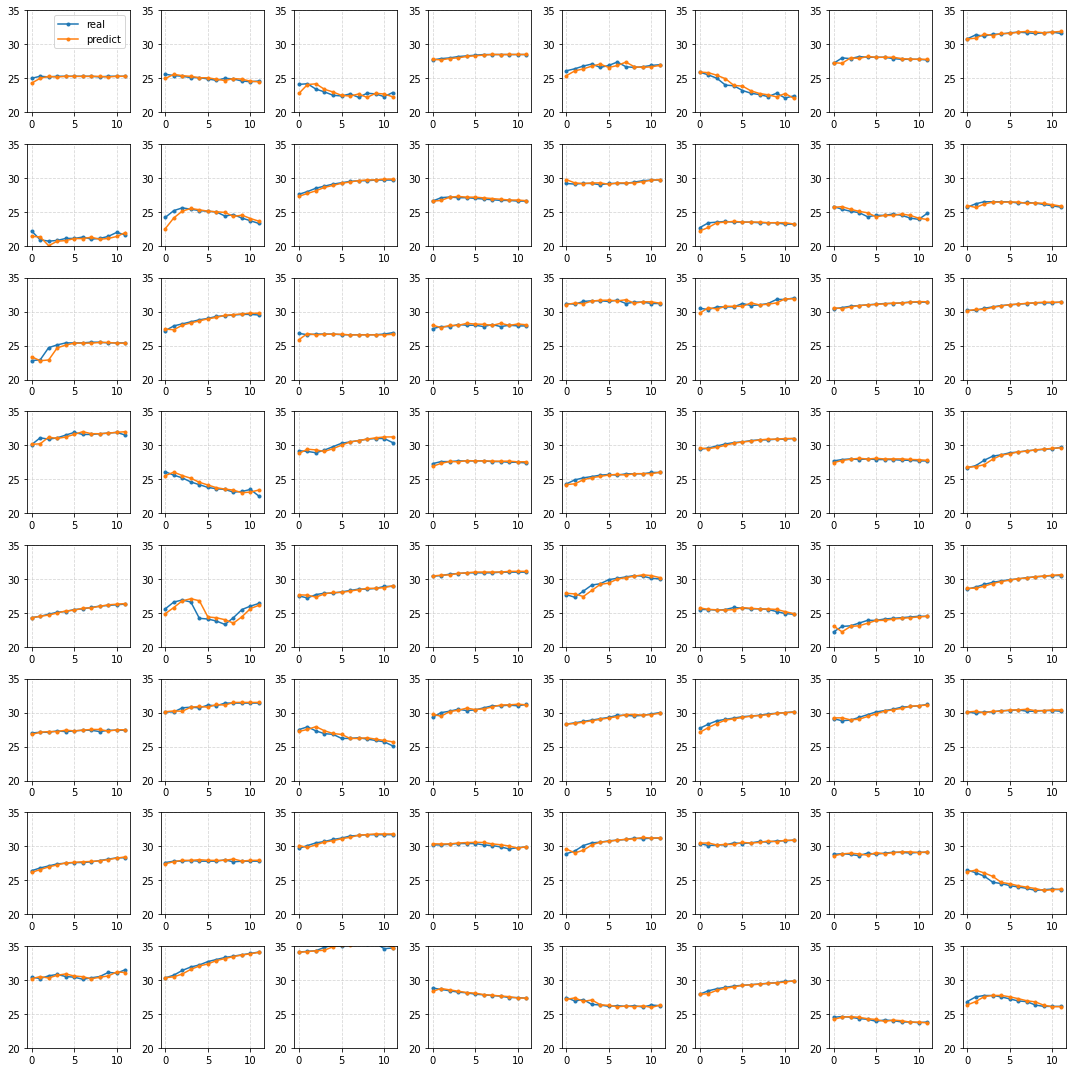

In [59]:
#SIN ACTUALIZAR
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k+i,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

### Pruebas

In [68]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)

In [69]:
def find_events(data, edificios, n_obs_antes, n_obs_despues, variables):
    #DataFrame vacío para la salida
    datos_all_rooms = pd.DataFrame()
    #import pandas as pd
    #Para que no haya problemas de slice y .loc
    pd.options.mode.chained_assignment = None
    
    #Cogemos los datos, y seleccionamos las habitaciones de cada edificio 
    datos = data
    edificio = edificios
    mask = datos['block'].isin(edificio)
    datos = datos.loc[mask]
    rooms = datos['room'].unique()
    
    #Iteramos sobre cada una de las habitaciones
    for room in rooms:
        mask = datos['room'].isin([room])
        datos_room = datos.loc[mask]
        if variables == 1:
            datos_room = datos_room[['V2','V4']]
        elif variables == 2:
            datos_room = datos_room.drop(columns=['dif_cons','cons_total','block','room', 'V12','V26','V5_0','V5_1','V5_2', 'Hora_1', 'Hora_2', 'Hora_3', 'Season_1', 'Season_2', 'Season_3', 'Season_4'],axis=1)
        elif variables == 3:
            datos_room = datos_room.drop(columns=['dif_cons','cons_total','block','room', 'V12','V26','V5_0','V5_1','V5_2'],axis=1)
        else: 
            print('var_mode error')
            break
        #Ponemos la columna de V4 como string y buscamos una secuencia de un 1 seguido de n 0's
        #El número de 0's lo establece n_obs_despues
        text = datos_room.V4.fillna(2).astype(int).astype(str).str.cat()
        time = n_obs_despues*10 #Esto nos da el tiempo en min. Ej: n_obs_despues = 6 -> time = 60'

        sequence = list(np.repeat(str(0),time/10))
        sequence.insert(0,'1'*n_obs_antes)
        sequence= ''.join(sequence)
        pattern = f'(?:{sequence})'
        findings = re.finditer(pattern, text)
        events = [(m.start(0)) for m in findings]  

        df = pd.DataFrame()
        #Para cada una de las secuencias de 1 y 0's, hacemos la selección de las instancias correspondientes
        #del conjunto de datos y las añadimos a un df, que iremos completando con cada uno de los eventos
        for i in range(len(events)):
            ref_inicio = events[i]+n_obs_antes #+1 porque la referencia de inicio es el primer 0 y events empieza en el 1
            df1 = datos_room.iloc[range(ref_inicio - n_obs_antes, ref_inicio + n_obs_despues),:]
            data = df1
            #Una vez que tenemos los eventos quitamos la columna de V4
            #data = data.drop(columns='V4')
            #n_vars = 1 if type(data) is list else data.shape[1]
            df = pd.concat([df,data])
        datos_all_rooms = pd.concat([datos_all_rooms, df])
    return datos_all_rooms

In [70]:
def fix_samples(n_obs_despues, n_obs_antes, train_x, test_x, val_x, train_y, test_y, val_y):
    train_x = train_x.reshape(train_x.shape[0],train_x.shape[2])
    test_x = test_x.reshape(test_x.shape[0],test_x.shape[2])
    val_x = val_x.reshape(val_x.shape[0],val_x.shape[2])
    rows_to_keep = n_obs_despues 
    rows_to_drop = n_obs_antes
    period = rows_to_keep + rows_to_drop
    
    train_sel = (np.arange(len(train_x)) % period) < rows_to_keep
    test_sel = (np.arange(len(test_x)) % period) < rows_to_keep
    val_sel = (np.arange(len(val_x)) % period) < rows_to_keep
    
    train_x = train_x[train_sel,:]
    train_y = train_y[train_sel,:] 
    test_x = test_x[test_sel,:]
    test_y = test_y[test_sel,:] 
    val_x = val_x[val_sel,:]
    val_y = val_y[val_sel,:] 
    return train_x, train_y, test_x, test_y, val_x, val_y

In [71]:
#ACTUALIZANDO
def predict(datos_test_x, datos_test_y, n_predict, n_obs_despues, model):
    test_y = datos_test_y
    test_x = datos_test_x
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos los índices i a 0
    i=0
    #Indice para hacer predicciones en un horizonte de tiempo concreto
    #Saltamos n filas cada m. Ej: tenemos n_obs_despues=12 pero queremos predecir solo la hora siguiente así
    #que predecimos 6 filas, saltamos otras 6 (que serían la 2a hora) y repetimos
    n = n_obs_despues - n_predict 
    m = n_predict   #Salto de n cada m
    test_index = [j for k in range(0,len(test_x), n+m) for j in range(k, m+k) if j<len(test_x)]
    for i in test_index:
        data = test_x[i,:]
        # Cogemos como input los valores del instante de tiempo anterior al que vamos a predecir
        # Recordar que el x lleva un lag de 1 respecto a la y, por eso es el elemento i y no el i-1
        # Le damos la forma que el modelo necesita para predecir
        input_x = data.reshape((1, test_x.shape[1]))
        
        # Prediccion para cada paso de tiempo
        yhat = model.predict(input_x, verbose=0)
        yhat_sequence = yhat[0] 

        # Guardamos las predicciones
        predictions.append(yhat_sequence)
        
        # Reescribimos el valor de la temperatura del siguiente paso con la prediccion
        # Añadimos una condición más para que en el último paso de cada evento no actualice, ya
        # que reescribiría datos de otro caso
        if i < len(test_x) and (i not in range(n_predict-1,len(test_x), n_obs_despues)):
            try: test_x[i+1,0] = yhat[0]
            except IndexError: continue
            #La excepción es porque al llegar al final no hay un i+1 que actualizar y salta un IndexError
        
    predictions = array(predictions)
    #Seleccionamos solo los ejemplos del conjunto de test que vamos a predecir
    test_y = test_y[test_index,:]
    return predictions, test_y

In [72]:
def metrics(test_y, prediction):
    rmse = np.sqrt(mean_squared_error(test_y,prediction))
    cvrmse = rmse/np.mean(test_y)*100
    r2 = r2_score(test_y, prediction)
    return cvrmse, r2, rmse

In [77]:
def prueba(obs_antes, obs_despues, pred_steps, block, data, variable_mode):
    edificio = block
    n_obs_antes = obs_antes
    n_obs_despues = obs_despues
    n_predict = pred_steps #Timesteps a predecir
    datos = data
    variables = variable_mode
    interval = n_obs_antes + n_obs_despues
    
    #Busqueda de patrón ON->OFF
    datos_all_rooms = find_events(datos, edificio, n_obs_antes, n_obs_despues, variables)
    
    df = datos_all_rooms
    #Reordenar muestras aleatoriamete
    df = shuffle_df(df, interval)
    
    #Split en train/val/test (70/15/15)
    per_train = 0.7
    per_test = 0.15
    train, test, val, scaler_x, scaler_y = split_dataset(df, per_train, per_test, interval, n_obs_antes, n_obs_despues)
   
    #Convertimos datos a aprendizaje supervisado
    n_input = n_obs_antes
    n_out = 1
    train_x, train_y = to_supervised(train, n_input, n_out)
    test_x, test_y = to_supervised(test, n_input, n_out)
    val_x, val_y = to_supervised(val, n_input, n_out)
    
    ##Quitamos muestras mezcladas
    train_x = train_x.reshape(train_x.shape[0],train_x.shape[2])
    test_x = test_x.reshape(test_x.shape[0],test_x.shape[2])
    val_x = val_x.reshape(val_x.shape[0],val_x.shape[2])
    rows_to_keep = n_obs_despues 
    rows_to_drop = n_obs_antes
    period = rows_to_keep + rows_to_drop

    train_sel = (np.arange(len(train_x)) % period) < rows_to_keep
    test_sel = (np.arange(len(test_x)) % period) < rows_to_keep
    val_sel = (np.arange(len(val_x)) % period) < rows_to_keep

    train_x = train_x[train_sel,:]
    train_y = train_y[train_sel,:] 
    test_x = test_x[test_sel,:]
    test_y = test_y[test_sel,:] 
    val_x = val_x[val_sel,:]
    val_y = val_y[val_sel,:] 
    #-----------------------Diseño del modelo-------------------- Lo hacemos aquí porque da problemas al usarlo desde el nb
    #Si n_pred es 12 y n_obs_despues es 12 cargamos el mismo modelo con n_pred=6 y n_obs_despues=12
    if n_obs_despues == n_predict == 12:
        model = keras.models.load_model('model_temp_mlp_0'+ str(variables) + '_predsteps' + '6' + '_post' + str(n_obs_despues) + '_prev' + str(n_obs_antes) + '.h5')
    #Si no estamos en ese caso hacemos el modelo
    else:
        def build_model(hp):
            model = Sequential()
            hp_units1 = hp.Choice('input_unit1',[25,50,100])
            model.add(Dense(units = hp_units1, input_dim=train_x.shape[1]))
            hp_units2 = hp.Choice('input_unit2',[25,50,100])
            model.add(Dense(units = hp_units2))
            hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
            model.add(Dropout(hp_dropout))
            model.add(Dense(1))
            hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
            return model

        tuner= BayesianOptimization(build_model,
                                    objective='val_loss', max_trials=15, num_initial_points=2, overwrite=True)
        stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
        tuner.search(x=train_x, y=train_y, epochs=200, batch_size=128, validation_data=(val_x,val_y),verbose=2,
                     shuffle=False, callbacks=[stop_early])
        model = tuner.get_best_models(num_models=1)[0]
    #------------------------------------------------------------------------------------------------------------
    
    #Predicciones
    prediction, test_y = predict(test_x, test_y, n_predict, n_obs_despues, model)
    #Reshape para poder calcular métricas
    pred_shape_0 = test.shape[0]
    pred_shape_1 = n_predict
    prediction = prediction.reshape(pred_shape_0, pred_shape_1)
    test_y = test_y.reshape(pred_shape_0, pred_shape_1)
    prediction = scaler_y.inverse_transform(prediction)
    test_y = scaler_y.inverse_transform(test_y)
    
    #Cálculamos métricas
    differences = np.abs(prediction-test_y).mean(axis=1)
    #differences = np.abs((prediction - test_y).mean(axis=1)).round(0).astype(int)
    cvrmse, r2, rmse = metrics(test_y, prediction)
    
    return model, cvrmse, r2, rmse, differences, test_y, prediction

In [78]:
obs_antes = [1] #1,3,6
obs_despues = [6,12]   #6,12
pred_steps = [6]    #6,12
block = ['A','B','C']
data = datos
var_mode = [1,2,3] # 1 = temp, 2 = temp+meteo, 3 = all

for i in obs_antes:
    for j in obs_despues:
        for k in pred_steps:
            for l in var_mode:
                print('obs_antes:', i, '| obs_despues', j, '| pred_steps:', k, '| var_mode', l)
                model, cvrmse, r2, rmse, differences, test_y, prediction = prueba(i, j, k, block, data, l)
                model.save('model_temp_mlp_0'+ str(l) + '_predsteps' + str(k) + '_post' + str(j) + '_prev' + str(i) + '.h5')
                results_metrics = pd.read_csv('model-temp-results_metrics.csv', sep=";")
                add_metrics = {'Modelo': 'MLP', 'Variables': '0'+str(l), 'steps_pred': k, 'n_obs_despues': j, 'n_obs_antes': i, 'CVRMSE': cvrmse, 'R2': r2, 'RMSE': rmse}
                results_metrics = results_metrics.append(add_metrics, ignore_index = True)
                results_metrics.to_csv('model-temp-results_metrics.csv', sep=";", index=False)
                results_preds = pd.read_csv('model-temp-results_preds.csv', sep=";")
                prediction = prediction.round(2)
                differences = differences.round(2)
                add_preds = pd.DataFrame({'Prueba': np.repeat('MLP-' + str(l) + '-' + str(k) +'-' + str(j) + '-' + str(i), len(test_y)),
                                        'test_y': test_y.tolist(),'prediction': prediction.tolist(),'difference': differences.tolist()})
                results_preds = pd.concat([results_preds, add_preds])
                results_preds.to_csv('model-temp-results_preds.csv', sep=";", index=False)
                print('Paso', i, j, k, l)

obs_antes: 3 | obs_despues 6 | pred_steps: 12 | var_mode 1

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
50                |?                 |input_unit1
100               |?                 |input_unit2
0                 |?                 |Dropout_rate
0.001             |?                 |learning_rate

Epoch 1/200


ValueError: in user code:

    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\anton\AppData\Roaming\Python\Python38\site-packages\keras\engine\input_spec.py", line 247, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected axis -1of input shape to have value 3, but received input with shape (None, 3, 2)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 3, 2), dtype=float32)
      • training=True
      • mask=None
